In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir Dataset_ResNet

!unzip -uq "/content/drive/MyDrive/Colab Notebooks/Dataset_ResNet.zip" -d "/content"

In [ ]:
import glob
from PIL import Image
import csv


import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras import metrics
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
#from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [ ]:
IMG_WIDTH = 224 #96
IMG_HEIGHT = 224 #256
IMG_CHANNELS = 1

directory_path = '/content/Dataset_ResNet'
subfolders = ['TestAV1', 'TestAV3', 'TestAV4', 'TestAV5', 'TestAV6', 'TestAV7', 'TestAV8']

file_path = '/content/Dataset_ResNet/Alicona_data.csv'

In [ ]:
X = np.zeros((170, IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.float32)
cnt = 0
for elmt in subfolders:
    subfolder_path = os.path.join(directory_path, elmt)
    train_image_files = glob.glob(os.path.join(subfolder_path, '*.tif'))
    train_image_files = sorted(train_image_files)  # Sort the file paths

    for img in train_image_files:
      im = tf.keras.preprocessing.image.load_img(img, grayscale=True)
      x_img = tf.keras.preprocessing.image.img_to_array(im)
      x_img = resize(x_img, (IMG_HEIGHT, IMG_WIDTH, 1), mode = 'constant', preserve_range = True)
      X[cnt] = x_img/255.0

      cnt +=1


# Create an empty list to store the data rows
csv_data = []

with open(file_path, 'r') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',')
    next(csvreader)
    for row in csvreader:
        csv_data.append(row)
        csv_data.append(row)
        csv_data.append(row)
        csv_data.append(row)
        csv_data.append(row)

csv_dataa = np.array(csv_data)

y = np.zeros((len(csv_dataa), 1), dtype=np.float32)
y = csv_dataa[:,2].astype(np.float32).reshape(-1, 1)

/usr/local/lib/python3.10/dist-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


In [ ]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(136, 224, 224, 3)
(136, 1)
(34, 224, 224, 3)
(34, 1)


In [ ]:
input_t = tf.keras.layers.Input(shape=(224,224,3))
res_model = tf.keras.applications.ResNet152(include_top=False, weights=None, input_tensor=input_t, input_shape=None)

In [ ]:
x = res_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dense(1024,activation='relu')(x)

model=Model(inputs=res_model.input,outputs=Dense(1, activation='linear')(x))

model.compile(loss = 'mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=50, verbose=1, mode='auto', restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_valid, y_valid), callbacks=[monitor], verbose = 1)

'''model = tf.keras.models.Sequential()
model.add(res_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(1, activation='linear'))

check_point = tf.keras.callbacks.ModelCheckpoint(filepath="cifar10.h5",
                                              monitor="val_acc",
                                              mode="max",
                                              save_best_only=True,
                                              )
model.compile(optimizer = 'adam', loss='mean_squared_error', metrics = ['mean_squared_error'])
history = model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1,
                        validation_data=(X_valid, y_valid),
                        callbacks=[check_point])
model.summary()'''

Epoch 1/100
5/5 [==============================] - 161s 2s/step - loss: 169.0696 - rmse: 13.0027 - val_loss: 0.1390 - val_rmse: 0.3729
Epoch 2/100
5/5 [==============================] - 4s 706ms/step - loss: 2.6347 - rmse: 1.6232 - val_loss: 1.3958 - val_rmse: 1.1814
Epoch 3/100
5/5 [==============================] - 4s 702ms/step - loss: 0.5947 - rmse: 0.7711 - val_loss: 1.3579 - val_rmse: 1.1653
Epoch 4/100
5/5 [==============================] - 4s 706ms/step - loss: 0.3469 - rmse: 0.5890 - val_loss: 1.0498 - val_rmse: 1.0246
Epoch 5/100
5/5 [==============================] - 4s 719ms/step - loss: 0.0611 - rmse: 0.2472 - val_loss: 1.0897 - val_rmse: 1.0439
Epoch 6/100
5/5 [==============================] - 4s 700ms/step - loss: 0.0550 - rmse: 0.2346 - val_loss: 0.8685 - val_rmse: 0.9319
Epoch 7/100
5/5 [==============================] - 4s 706ms/step - loss: 0.0403 - rmse: 0.2008 - val_loss: 0.8362 - val_rmse: 0.9144
Epoch 8/100
5/5 [==============================] - 4s 714ms/step - 

'model = tf.keras.models.Sequential()\nmodel.add(res_model)\nmodel.add(tf.keras.layers.Flatten())\nmodel.add(tf.keras.layers.BatchNormalization())\nmodel.add(tf.keras.layers.Dense(256, activation=\'relu\'))\nmodel.add(tf.keras.layers.Dropout(0.5))\nmodel.add(tf.keras.layers.BatchNormalization())\nmodel.add(tf.keras.layers.Dense(128, activation=\'relu\'))\nmodel.add(tf.keras.layers.Dropout(0.5))\nmodel.add(tf.keras.layers.BatchNormalization())\nmodel.add(tf.keras.layers.Dense(64, activation=\'relu\'))\nmodel.add(tf.keras.layers.Dropout(0.5))\nmodel.add(tf.keras.layers.BatchNormalization())\nmodel.add(tf.keras.layers.Dense(1, activation=\'linear\'))\n\ncheck_point = tf.keras.callbacks.ModelCheckpoint(filepath="cifar10.h5",\n                                              monitor="val_acc",\n                                              mode="max",\n                                              save_best_only=True,\n                                              )\nmodel.compile(optimizer = 

In [ ]:

model.evaluate(X_valid, y_valid, batch_size=128, verbose=1)

1/1 [==============================] - 2s 2s/step - loss: 0.0289 - rmse: 0.1701


[0.028930095955729485, 0.1700884848833084]

In [ ]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

2/2 [==============================] - 0s 238ms/step


In [ ]:
print(y_train[0])
print(preds_train[0])

[1.175]
[1.1718678]


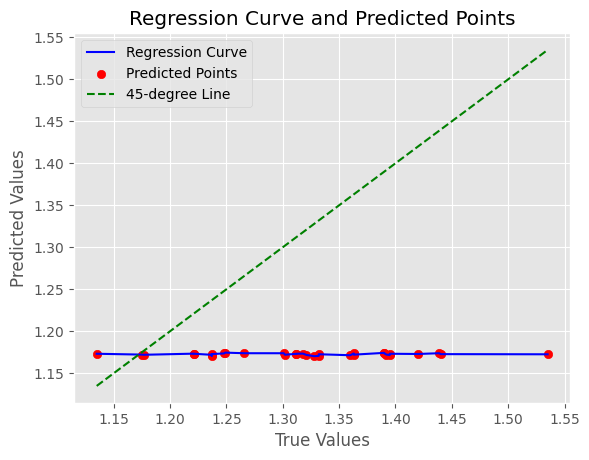

In [ ]:
ground_truth = y_valid
pred = preds_val
# Sort the data by ground truth values for plotting the regression curve
sorted_indices = np.argsort(ground_truth.flatten())
sorted_ground_truth = ground_truth[sorted_indices]
sorted_predictions = pred[sorted_indices]

# Plot the regression curve
plt.plot(sorted_ground_truth, sorted_predictions, color='blue', label='Regression Curve')

# Plot the predicted points against real values
plt.scatter(ground_truth, pred, color='red', label='Predicted Points')

# Add a 45-degree line for reference (y=x)
x_min, x_max = np.min(ground_truth), np.max(ground_truth)
plt.plot([x_min, x_max], [x_min, x_max], color='green', linestyle='--', label='45-degree Line')

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Regression Curve and Predicted Points')
plt.legend()
plt.show()

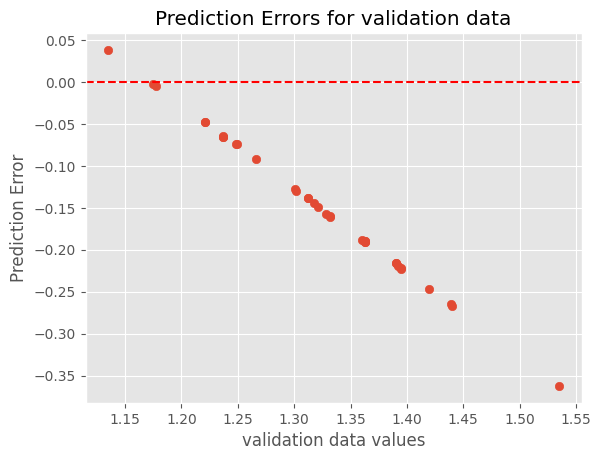

In [ ]:
errors = preds_val - y_valid

# Plot the residuals/errors
plt.scatter(y_valid, errors)
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0 for reference
plt.xlabel('validation data values')
plt.ylabel('Prediction Error')
plt.title('Prediction Errors for validation data')
plt.show()